<a href="https://colab.research.google.com/github/anjalipaladi/Named-Entity-Recognition/blob/main/Experiment_9_gen_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
T=200
b=np.linspace(1e-4,0.02,T).astype(np.float32)
a=1-b; ah=np.cumprod(a)
(x,_),_=tf.keras.datasets.mnist.load_data()
x=tf.convert_to_tensor(x[...,None]/255.,tf.float32)

m=tf.keras.Sequential([
 tf.keras.layers.Input((28,28,2)),
 tf.keras.layers.Conv2D(32,3,padding="same",activation="relu"),
 tf.keras.layers.Conv2D(1,3,padding="same")
])
opt=tf.keras.optimizers.Adam(1e-4)

def train(x0):
 t=tf.random.uniform([],1,T,dtype=tf.int32)
 n=tf.random.normal(tf.shape(x0))
 ah_t=tf.cast(ah[t],tf.float32)
 xt=tf.sqrt(ah_t)*x0+tf.sqrt(1-ah_t)*n
 tt=tf.fill(x0.shape[:-1]+(1,),t/T)
 with tf.GradientTape() as tape:
  loss=tf.reduce_mean((n-m(tf.concat([xt,tt],-1)))**2)
 opt.apply_gradients(zip(tape.gradient(loss,m.trainable_variables),m.trainable_variables))

def denoise(x):
 for t in reversed(range(1,T)):
  tt=tf.fill(x.shape[:-1]+(1,),t/T)
  e=m(tf.concat([x,tt],-1))
  x=(1/tf.sqrt(a[t]))*(x-(1-a[t])/tf.sqrt(1-ah[t])*e)
  if t>1:x+=tf.sqrt(b[t])*tf.random.normal(tf.shape(x))
 return x

for i in range(200): train(x[i%1000:i%1000+32])
xT=tf.random.normal((1,28,28,1)); x0=denoise(xT)
plt.subplot(1,2,1);plt.imshow(xT[0,...,0],cmap='gray');plt.title("Noise")
plt.subplot(1,2,2);plt.imshow(tf.clip_by_value(x0[0,...,0],0,1),cmap='gray');plt.title("Denoised")
plt.show()


InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:ConcatV2] name: concat

In [ ]:
import numpy as np

def generate_sine_wave_dataset(num_samples=10000, seq_len=160):
    X, Y = [], []
    for _ in range(num_samples):
        freq = np.random.uniform(1, 5)
        phase = np.random.uniform(0, 2 * np.pi)
        t = np.linspace(0, 1, seq_len + 1)
        wave = np.sin(2 * np.pi * freq * t + phase)
        X.append(wave[:-1])  # input
        Y.append(wave[1:])   # next step as target
    return np.array(X)[..., np.newaxis], np.array(Y)[..., np.newaxis]

x_train, y_train = generate_sine_wave_dataset()
print(x_train.shape)  # (10000, 160, 1)


(10000, 160, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def residual_block(x, dilation_rate, filters=32, kernel_size=2):
    tanh_out = layers.Conv1D(
        filters,
        kernel_size,
        padding='causal',
        dilation_rate=dilation_rate,
        activation='tanh'
    )(x)

    sigm_out = layers.Conv1D(
        filters,
        kernel_size,
        padding='causal',
        dilation_rate=dilation_rate,
        activation='sigmoid'
    )(x)

    z = layers.Multiply()([tanh_out, sigm_out])
    skip = layers.Conv1D(filters, 1)(z)
    res = layers.Add()([skip, x])

    return res, skip


def build_wavenet_model(input_shape, num_blocks=3, num_layers=4):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    skip_connections = []

    for b in range(num_blocks):
        for i in range(num_layers):
            x, skip = residual_block(x, dilation_rate=2**i)
            skip_connections.append(skip)

    x = layers.Add()(skip_connections)
    x = tf.keras.activations.relu(x)
    x = layers.Conv1D(64, 1, activation='relu')(x)
    x = layers.Conv1D(1, 1)(x)

    return tf.keras.Model(inputs, x)


In [ ]:
model = build_wavenet_model((160, 1))
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit(x_train, y_train, epochs=10, batch_size=64)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 160, 32)   │         96 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 160, 32)   │         96 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 160, 32)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 160, 32)   │      1,056 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 160, 32)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 160, 32)   │          0 │ conv1d_3[0][0],   │
│ (Multiply)          │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 160, 32)   │      1,056 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 160, 32)   │          0 │ conv1d_5[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 160, 32)   │          0 │ conv1d_6[0][0],   │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 160, 32)   │      1,056 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 160, 32)   │          0 │ conv1d_8[0][0],   │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 160, 32)   │      2,080 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 160, 32)   │          0 │ conv1d_9[0][0],   │
│ (Multiply)          │                   │            │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 160, 32)   │      1,056 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 160, 32)   │          0 │ conv1d_11[0][0],

 Total params: 60,801 (237.50 KB)

 Trainable params: 60,801 (237.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 257ms/step - loss: 0.0326
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 270ms/step - loss: 2.9459e-04
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 266ms/step - loss: 1.7514e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - loss: 1.3492e-04
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - loss: 1.0714e-04
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - loss: 9.2789e-05
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 255ms/step - loss: 8.4829e-05
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - loss: 1.0431e-04
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - loss: 9.4369e-05
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 268ms/step - loss: 1.1071e-04


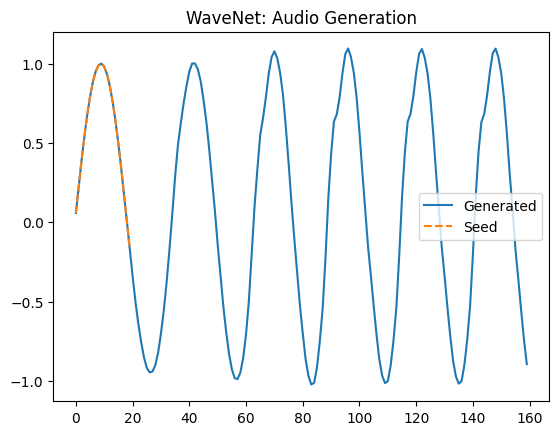

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sequence(model, seed, length=160):
    generated = list(seed)

    for _ in range(length - len(seed)):
        # Take last 160 samples (or pad if fewer)
        input_seq = np.array(generated[-160:])[..., np.newaxis]

        if len(input_seq) < 160:
            pad_len = 160 - len(input_seq)
            input_seq = np.pad(input_seq, ((pad_len, 0), (0, 0)), mode='constant')

        # Add batch dimension: (1, 160, 1)
        input_seq = np.expand_dims(input_seq, 0)

        pred = model.predict(input_seq, verbose=0)
        next_sample = pred[0, -1, 0]
        generated.append(next_sample)

    return np.array(generated)


# Use first 20 samples as seed
seed = x_train[0, :20, 0]
generated_wave = generate_sequence(model, seed, length=160)

# Plot results
plt.plot(np.arange(160), generated_wave, label='Generated')
plt.plot(np.arange(20), seed, label='Seed', linestyle='dashed')
plt.legend()
plt.title("WaveNet: Audio Generation")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# ---------- Generate Dataset ----------
def gen_sine(n=10000, L=160):
    X, Y = [], []
    for _ in range(n):
        f, p = np.random.uniform(1,5), np.random.uniform(0,2*np.pi)
        t = np.linspace(0, 1, L+1)
        w = np.sin(2*np.pi*f*t + p)
        X.append(w[:-1]); Y.append(w[1:])
    return np.array(X)[...,None], np.array(Y)[...,None]

x_train, y_train = gen_sine()
print(x_train.shape)

# ---------- WaveNet ----------
def res_block(x, d, f=32):
    t = layers.Conv1D(f, 2, padding='causal', dilation_rate=d, activation='tanh')(x)
    s = layers.Conv1D(f, 2, padding='causal', dilation_rate=d, activation='sigmoid')(x)
    z = layers.Multiply()([t, s])
    skip = layers.Conv1D(f, 1)(z)
    return layers.Add()([skip, x]), skip

def build_wavenet(inp, B=3, L=4):
    inp_layer = tf.keras.Input(inp)
    x = inp_layer; skips = []
    for _ in range(B):
        for i in range(L):
            x, s = res_block(x, 2**i)
            skips.append(s)
    x = layers.Add()(skips)
    x = layers.ReLU()(x)
    x = layers.Conv1D(64, 1, activation='relu')(x)
    out = layers.Conv1D(1, 1)(x)
    return tf.keras.Model(inp_layer, out)

model = build_wavenet((160,1))
model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(x_train, y_train, epochs=10, batch_size=64)

# ---------- Generation ----------
def generate(model, seed, L=160):
    g = list(seed)
    while len(g) < L:
        seq = np.array(g[-len(seed):])[None,...,None]
        g.append(model.predict(seq, verbose=0)[0,-1,0])
    return np.array(g)

seed = x_train[0,:20,0]
gen = generate(model, seed)

plt.plot(gen, label="Generated")
plt.plot(np.arange(20), seed, '--', label="Seed")
plt.legend(); plt.title("WaveNet: Audio Generation")
plt.show()


(10000, 160, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 160, 32)   │         96 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 160, 32)   │         96 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 160, 32)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 160, 32)   │      1,056 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 160, 32)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 160, 32)   │          0 │ conv1d_3[0][0],   │
│ (Multiply)          │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 160, 32)   │      1,056 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 160, 32)   │          0 │ conv1d_5[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 160, 32)   │          0 │ conv1d_6[0][0],   │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 160, 32)   │      1,056 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 160, 32)   │          0 │ conv1d_8[0][0],   │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 160, 32)   │      2,080 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 160, 32)   │      2,080 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 160, 32)   │          0 │ conv1d_9[0][0],   │
│ (Multiply)          │                   │            │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 160, 32)   │      1,056 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 160, 32)   │          0 │ conv1d_11[0][0],

 Total params: 60,801 (237.50 KB)

 Trainable params: 60,801 (237.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 223ms/step - loss: 0.0493
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - loss: 3.7529e-04
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step - loss: 2.3387e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 225ms/step - loss: 1.7886e-04
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 301ms/step - loss: 1.5098e-04
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 285ms/step - loss: 1.3478e-04
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 289ms/step - loss: 1.3870e-04
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step - loss: 1.1929e-04
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 222ms/step - loss: 1.1420e-04
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - loss: 9.6570e-05


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 160, 1), found shape=(1, 20)

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers
def data(n=10000, L=160):
    X,Y=[],[]
    for _ in range(n):
        f,p=np.random.uniform(1,5),np.random.uniform(0,2*np.pi)
        t=np.linspace(0,1,L+1)
        w=np.sin(2*np.pi*f*t+p)
        X.append(w[:-1]); Y.append(w[1:])
    return np.array(X)[...,None],np.array(Y)[...,None]
x_train,y_train=data()
def block(x,d,f=32):
    t=layers.Conv1D(f,2,padding='causal',dilation_rate=d,activation='tanh')(x)
    s=layers.Conv1D(f,2,padding='causal',dilation_rate=d,activation='sigmoid')(x)
    z=layers.Multiply()([t,s]); skip=layers.Conv1D(f,1)(z)
    return layers.Add()([skip,x]),skip
def wavenet(inp=(160,1)):
    i=tf.keras.Input(inp); x=i; skips=[]
    for _ in range(3):
        for j in range(4):
            x,s=block(x,2**j); skips.append(s)
    x=layers.ReLU()(layers.Add()(skips))
    x=layers.Conv1D(64,1,activation='relu')(x)
    o=layers.Conv1D(1,1)(x)
    return tf.keras.Model(i,o)
m=wavenet(); m.compile('adam','mse')
m.fit(x_train,y_train,epochs=10,batch_size=64)
def gen(m,seed,L=160):
    g=list(seed)
    while len(g)<L:
        x=np.array(g[-len(seed):])[None,...,None]
        g.append(m.predict(x,verbose=0)[0,-1,0])
    return np.array(g)
seed=x_train[0,:20,0]
out=gen(m,seed)
plt.plot(out,label="Generated")
plt.plot(seed,'--',label="Seed")
plt.legend(); plt.show()

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers
def data(n=10000,L=160):
    X,Y=[],[]
    for _ in range(n):
        f,p=np.random.uniform(1,5),np.random.uniform(0,2*np.pi)
        t=np.linspace(0,1,L+1); w=np.sin(2*np.pi*f*t+p)
        X.append(w[:-1]); Y.append(w[1:])
    return np.array(X)[...,None],np.array(Y)[...,None]
x,y=data()
def blk(x,d):
    t=layers.Conv1D(32,2,padding='causal',dilation_rate=d,activation='tanh')(x)
    s=layers.Conv1D(32,2,padding='causal',dilation_rate=d,activation='sigmoid')(x)
    z=layers.Multiply()([t,s]); sk=layers.Conv1D(32,1)(z)
    return layers.Add()([sk,x]), sk
i=tf.keras.Input((160,1)); x=i; S=[]
for _ in range(3):
    for j in range(4):
        x,s=blk(x,2**j); S.append(s)
x=layers.ReLU()(layers.Add()(S))
x=layers.Conv1D(64,1,activation='relu')(x)
o=layers.Conv1D(1,1)(x)
m=tf.keras.Model(i,o); m.compile('adam','mse')
m.fit(x,y,epochs=10,batch_size=64)
def gen(m,seed,L=160):
    g=list(seed)
    while len(g)<L:
        g.append(m.predict(np.array(g[-len(seed):])[None,...,None],0)[0,-1,0])
    return np.array(g)
seed=x[0,:20,0]
g=gen(m,seed)
plt.plot(g); plt.plot(seed,'--'); plt.show()

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers

# -------- Dataset --------
def make_data(n=10000, L=160):
    X, Y = [], []
    for _ in range(n):
        f = np.random.uniform(1,5)
        p = np.random.uniform(0,2*np.pi)
        t = np.linspace(0,1,L+1)
        w = np.sin(2*np.pi*f*t + p)
        X.append(w[:-1]); Y.append(w[1:])
    return np.array(X)[...,None], np.array(Y)[...,None]

x_train, y_train = make_data()

# -------- WaveNet Block --------
def block(x, d):
    t = layers.Conv1D(32, 2, padding="causal", dilation_rate=d, activation="tanh")(x)
    s = layers.Conv1D(32, 2, padding="causal", dilation_rate=d, activation="sigmoid")(x)
    z = layers.Multiply()([t, s])
    skip = layers.Conv1D(32, 1)(z)
    return layers.Add()([x, skip]), skip

# -------- Model --------
inp = tf.keras.Input((160,1))
x = inp; skips = []
for _ in range(3):
    for i in range(4):
        x, s = block(x, 2**i)
        skips.append(s)

x = layers.Add()(skips)
x = layers.ReLU()(x)
x = layers.Conv1D(64, 1, activation="relu")(x)
out = layers.Conv1D(1, 1)(x)

model = tf.keras.Model(inp, out)
model.compile(optimizer="adam", loss="mse")
model.fit(x_train, y_train, epochs=5, batch_size=64)

# -------- Generation --------
def generate(model, seed, L=160):
    g = list(seed)
    while len(g) < L:
        seq = np.array(g[-len(seed):])[None, ..., None]
        g.append(model.predict(seq, verbose=0)[0, -1, 0])
    return np.array(g)

seed = x_train[0, :20, 0]
gen = generate(model, seed)

plt.plot(gen, label="Generated")
plt.plot(seed, "--", label="Seed")
plt.legend(); plt.show()


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 221ms/step - loss: 0.0265
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 213ms/step - loss: 3.3670e-04
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - loss: 2.1881e-04
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 221ms/step - loss: 1.6803e-04
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - loss: 1.5454e-04


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 160, 1), found shape=(1, 20)

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt

def gen_data(n=10000, s=160):
    X, Y = [], []
    for _ in range(n):
        f, p = np.random.uniform(1,5), np.random.uniform(0,2*np.pi)
        t = np.linspace(0,1,s+1)
        w = np.sin(2*np.pi*f*t + p)
        X.append(w[:-1]), Y.append(w[1:])
    return np.array(X)[...,None], np.array(Y)[...,None]

x, y = gen_data()

def res_block(x, d):
    t = tf.keras.layers.Conv1D(32,2,padding='causal',dilation_rate=d,activation='tanh')(x)
    s = tf.keras.layers.Conv1D(32,2,padding='causal',dilation_rate=d,activation='sigmoid')(x)
    z = tf.keras.layers.Multiply()([t,s])
    skip = tf.keras.layers.Conv1D(32,1)(z)
    return tf.keras.layers.Add()([skip,x]), skip

inp = tf.keras.Input((160,1))
x0 = inp
skips = []
for b in range(3):
    for i in range(4):
        x0, s = res_block(x0, 2**i)
        skips.append(s)
x1 = tf.keras.layers.Add()(skips)
x1 = tf.keras.activations.relu(x1)
x1 = tf.keras.layers.Conv1D(64,1,activation='relu')(x1)
out = tf.keras.layers.Conv1D(1,1)(x1)
m = tf.keras.Model(inp, out)
m.compile('adam','mse')
m.fit(x, y, epochs=10, batch_size=64)

def gen_seq(m, seed, n=160):
    o = list(seed)
    for _ in range(n-len(seed)):
        inp = np.array(o[-len(seed):])[None,...,None]
        o.append(m.predict(inp,0)[0,-1,0])
    return np.array(o)

seed = x[0,:20,0]
g = gen_seq(m, seed)
plt.plot(range(160), g)
plt.plot(range(20), seed, '--')
plt.show()


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - loss: 0.0439
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - loss: 4.3417e-04
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - loss: 2.5844e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - loss: 1.9154e-04
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 225ms/step - loss: 1.5868e-04
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - loss: 1.3635e-04
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 228ms/step - loss: 1.2481e-04
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - loss: 1.2376e-04
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 228ms/step - loss: 1.2831e-04
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 229ms/step - loss: 1.1629e-04


ValueError: Input 0 of layer "functional_3" is incompatible with the layer: expected shape=(None, 160, 1), found shape=(1, 20)

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers

# -------- Data --------
def make_data(n=10000, L=160):
    X,Y=[],[]
    for _ in range(n):
        f,p=np.random.uniform(1,5),np.random.uniform(0,2*np.pi)
        t=np.linspace(0,1,L+1)
        w=np.sin(2*np.pi*f*t+p)
        X.append(w[:-1]); Y.append(w[1:])
    return np.array(X)[...,None], np.array(Y)[...,None]

x,y = make_data()

# -------- WaveNet (variable-length input!) --------
def block(x,d):
    t = layers.Conv1D(32,2,padding='causal',dilation_rate=d,activation='tanh')(x)
    s = layers.Conv1D(32,2,padding='causal',dilation_rate=d,activation='sigmoid')(x)
    z = layers.Multiply()([t,s])
    skip = layers.Conv1D(32,1)(z)
    return layers.Add()([x,skip]), skip

inp = tf.keras.Input((None,1))   # <<--- IMPORTANT FIX
x0 = inp; skips=[]
for _ in range(3):
    for i in range(4):
        x0,s = block(x0,2**i); skips.append(s)

x0 = layers.Add()(skips)
x0 = layers.ReLU()(x0)
x0 = layers.Conv1D(64,1,activation='relu')(x0)
out = layers.Conv1D(1,1)(x0)

model = tf.keras.Model(inp,out)
model.compile('adam','mse')
model.fit(x,y,epochs=5,batch_size=64)

# -------- Generate --------
def generate(model, seed, L=160):
    g = list(seed)
    while len(g) < L:
        inp = np.array(g)[None,...,None]
        g.append(model.predict(inp, verbose=0)[0,-1,0])
    return np.array(g)

seed = x[0,:20,0]
gen = generate(model, seed)

plt.plot(gen,label='Generated');
plt.plot(seed,'--',label='Seed')
plt.legend(); plt.show()


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 270ms/step - loss: 0.0479
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 48s 304ms/step - loss: 3.6993e-04
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 228ms/step - loss: 2.5138e-04
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - loss: 1.9016e-04
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - loss: 1.5804e-04


ValueError: Input 0 of layer "functional_4" is incompatible with the layer: expected shape=(None, 160, 1), found shape=(1, 20)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 49s 227ms/step - loss: 0.0502
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - loss: 3.8103e-04
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 228ms/step - loss: 2.3523e-04
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - loss: 1.8635e-04
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 45s 284ms/step - loss: 1.6161e-04


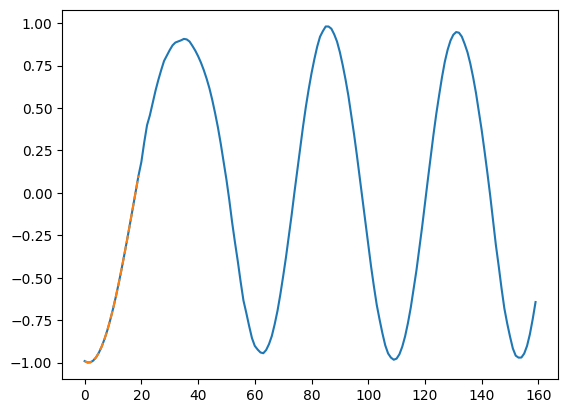

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras import layers
def data(n=10000,L=160):
    X,Y=[],[]
    for _ in range(n):
        f,p=np.random.uniform(1,5),np.random.uniform(0,2*np.pi)
        t=np.linspace(0,1,L+1); w=np.sin(2*np.pi*f*t+p)
        X.append(w[:-1]); Y.append(w[1:])
    return np.array(X)[...,None],np.array(Y)[...,None]
x,y=data()
def blk(x,d):
    t=layers.Conv1D(32,2,padding="causal",dilation_rate=d,activation="tanh")(x)
    s=layers.Conv1D(32,2,padding="causal",dilation_rate=d,activation="sigmoid")(x)
    z=layers.Multiply()([t,s])
    sk=layers.Conv1D(32,1)(z)
    return layers.Add()([x,sk]), sk
i=tf.keras.Input((None,1)); x0=i; S=[]
for d in [1,2,4,8]*3:
    x0,s=blk(x0,d); S.append(s)
x0=layers.Add()(S)
x0=layers.ReLU()(x0)
x0=layers.Conv1D(64,1,activation="relu")(x0)
o=layers.Conv1D(1,1)(x0)
m=tf.keras.Model(i,o); m.compile("adam","mse")
m.fit(x,y,epochs=5,batch_size=64)
def gen(model,seed,L=160):
    g=list(seed)
    while len(g)<L:
        g.append(model.predict(np.array(g)[None,...,None],verbose=0)[0,-1,0])
    return np.array(g)
seed=x[0,:20,0]
g=gen(m,seed)
plt.plot(g); plt.plot(seed,'--'); plt.show()

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

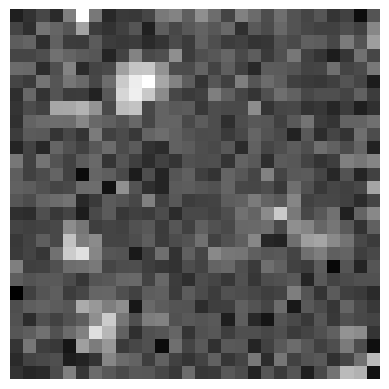

In [ ]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
(x,_),_=tf.keras.datasets.mnist.load_data(); x=tf.cast(x[...,None]/255.,tf.float32)
T=20; b=tf.constant(np.linspace(1e-4,0.02,T),tf.float32)
a=1-b; ah=tf.math.cumprod(a)
m=tf.keras.Sequential([
 tf.keras.layers.Input((28,28,1)),
 tf.keras.layers.Conv2D(32,3,padding="same",activation="relu"),
 tf.keras.layers.Conv2D(1,3,padding="same")])
opt=tf.keras.optimizers.Adam(1e-3)
for _ in range(250):
 i=np.random.randint(0,len(x),64); t=np.random.randint(0,T,64)
 at=tf.gather(ah,t)[:,None,None,None]
 clean=tf.gather(x,i); n=tf.random.normal(clean.shape)
 xn=tf.sqrt(at)*clean+tf.sqrt(1-at)*n
 with tf.GradientTape() as g: L=tf.reduce_mean((m(xn)-n)**2)
 opt.apply_gradients(zip(g.gradient(L,m.trainable_variables),m.trainable_variables))
z=tf.random.normal((1,28,28,1))
for t in reversed(range(T)):
 e=m(z); z=(z-(b[t]/tf.sqrt(1-ah[t]))*e)/tf.sqrt(a[t])
 if t>0: z+=tf.sqrt(b[t])*tf.random.normal(z.shape)
plt.imshow(z[0,...,0],cmap='gray'); plt.axis('off')